In [3]:
!pip install scikit-learn pandas numpy matplotlib seaborn streamlit nltk


In [4]:
import pandas as pd

df = pd.read_json("/content/problems_data.jsonl", lines=True)
df.head()


,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


In [5]:
df.shape

(4112, 8)

In [6]:
df.columns

Index(['title', 'description', 'input_description', 'output_description',
       'sample_io', 'problem_class', 'problem_score', 'url'],
      dtype='object')

In [7]:
df.dtypes

,0
title,object
description,object
input_description,object
output_description,object
sample_io,object
problem_class,object
problem_score,float64
url,object


In [8]:
df.isnull().sum()


,0
title,0
description,0
input_description,0
output_description,0
sample_io,0
problem_class,0
problem_score,0
url,0


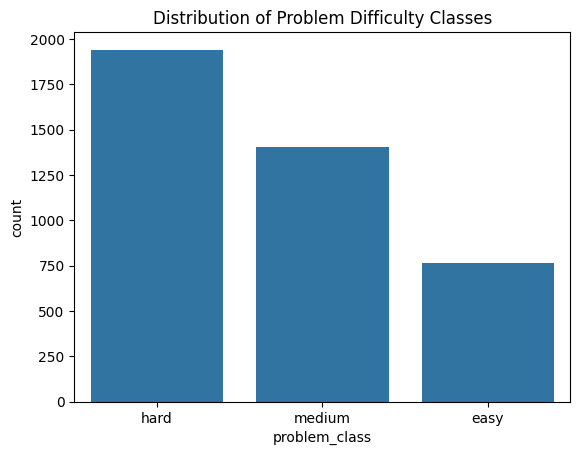

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='problem_class', data=df)
plt.title("Distribution of Problem Difficulty Classes")
plt.show()


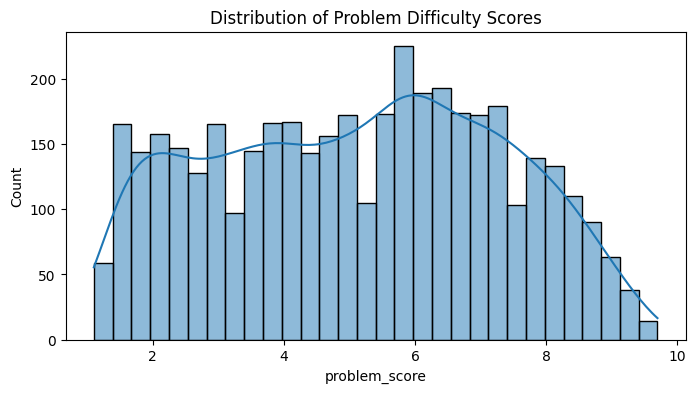

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df['problem_score'], bins=30, kde=True)
plt.title("Distribution of Problem Difficulty Scores")
plt.show()


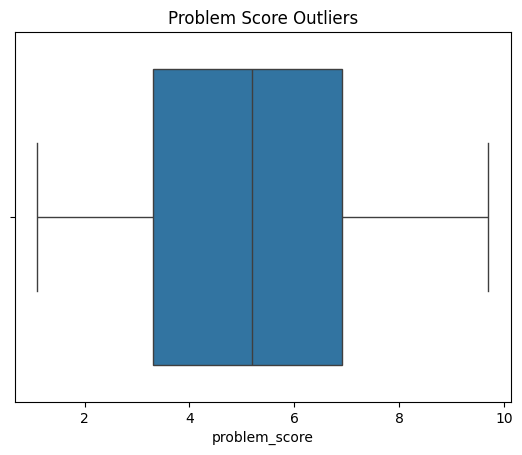

In [11]:
sns.boxplot(x=df['problem_score'])
plt.title("Problem Score Outliers")
plt.show()


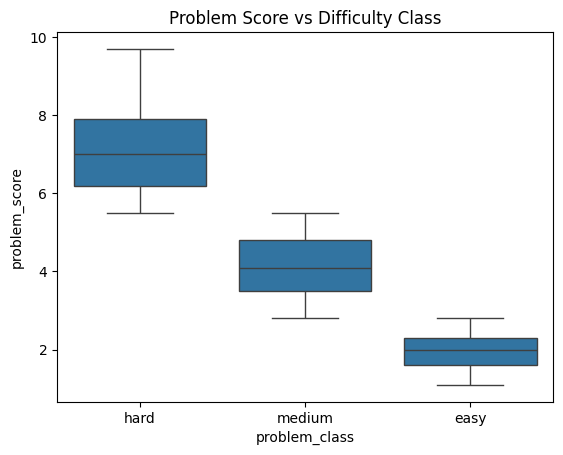

In [12]:
sns.boxplot(x='problem_class', y='problem_score', data=df)
plt.title("Problem Score vs Difficulty Class")
plt.show()


In [13]:
text_cols = ['title', 'description', 'input_description', 'output_description']

for col in text_cols:
    if col in df.columns:
        df[col + '_len'] = df[col].astype(str).apply(len)


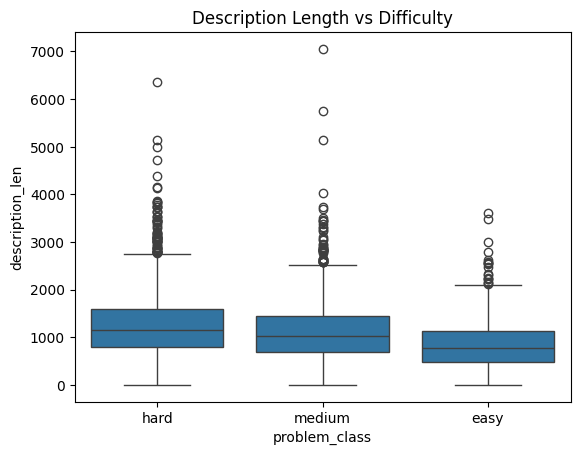

In [14]:
sns.boxplot(x='problem_class', y='description_len', data=df)
plt.title("Description Length vs Difficulty")
plt.show()


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

hard_text = df[df['problem_class']=='hard']['description']

cv = CountVectorizer(stop_words='english', max_features=20)
X = cv.fit_transform(hard_text)

cv.get_feature_names_out()


array(['different', 'exactly', 'example', 'game', 'given', 'help', 'left',
       'line', 'make', 'new', 'number', 'order', 'point', 'points',
       'possible', 'right', 'sequence', 'string', 'time', 'times'],
      dtype=object)

In [16]:
df['problem_class'] = df['problem_class'].str.lower()


In [17]:
def stringify_sample_io(sample_io):
    if isinstance(sample_io, list):
        parts = []
        for item in sample_io:
            if isinstance(item, dict):
                for v in item.values():
                    parts.append(str(v))
            else:
                parts.append(str(item))
        return " ".join(parts)
    elif isinstance(sample_io, dict):
        return " ".join(str(v) for v in sample_io.values())
    else:
        return str(sample_io)


In [18]:
def combine_text(row):
    return " ".join([
        str(row['title']),
        str(row['description']),
        str(row['input_description']),
        str(row['output_description']),
        stringify_sample_io(row['sample_io'])
    ])

df['full_text'] = df.apply(combine_text, axis=1)

In [19]:
df['full_text'].head(2)

,full_text
0,Uuu Unununium (Uuu) was the name of the chemic...
1,House Building A number of eccentrics from cen...


In [20]:
df['full_text'].str.len().describe()

,full_text
count,4112.000000
mean,1730.751459
std,796.066694
min,124.000000
25%,1190.000000
50%,1611.500000
75%,2126.000000
max,7862.000000


In [21]:
df['text_len'] = df['full_text'].str.len()

In [22]:
symbols = ['+', '-', '*', '/', '=', '<', '>', '%']

def count_symbols(text):
    return sum(text.count(s) for s in symbols)

df['symbol_count'] = df['full_text'].apply(count_symbols)

In [24]:
import re
import numpy as np
df["line_count"] = df["full_text"].str.count("\n")
df["constraint_mentions"] = df["full_text"].str.contains("constraint|limit|bound", case=False).astype(int)
df["dp_keyword"] = df["full_text"].str.contains("dynamic programming|dp", case=False).astype(int)
df["graph_keyword"] = df["full_text"].str.contains("graph|tree|dfs|bfs", case=False).astype(int)
df['greedy_keyword'] = df['full_text'].str.lower().str.contains('greedy|optimal', case=False).astype(int)
df['string_keyword'] = df['full_text'].str.lower().str.contains('string|substring|character', case=False).astype(int)
df['array_keyword'] = df['full_text'].str.lower().str.contains('array|sequence|list', case=False).astype(int)

df['word_count'] = df['full_text'].str.split().str.len()
df['optimal_mentions'] = df['full_text'].str.lower().str.contains('optimal|minimum|maximum').astype(int)

data_structures = ['array', 'tree', 'graph', 'stack', 'queue', 'heap', 'hash', 'matrix']
df['data_structure_count'] = df['full_text'].apply(
    lambda x: sum(x.lower().count(ds) for ds in data_structures)
)
df['number_count'] = df['full_text'].apply(lambda x: len(re.findall(r'\d+', x)))

df['sentence_count'] = df['full_text'].apply(lambda x: len(re.split(r'[.!?]+', x)))
df['avg_word_length'] = df['full_text'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)
df['big_o_mentioned'] = df['full_text'].str.contains(r'O\(', case=False).astype(int)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=500,
    ngram_range=(1,2),
    stop_words='english',
    min_df=3,
    max_df=0.8,
    sublinear_tf=True
)

X_tfidf = tfidf.fit_transform(df['full_text'])

In [26]:
X_tfidf.shape

(4112, 500)

In [27]:
hf =["text_len", "symbol_count", "line_count",
     "constraint_mentions", "dp_keyword", "graph_keyword","greedy_keyword","string_keyword","array_keyword","word_count","optimal_mentions","data_structure_count","number_count","sentence_count","avg_word_length","big_o_mentioned"]
X_hand = df[hf].values

y_class = df['problem_class']
y_score = df['problem_score']


In [28]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, \
X_train_hand, X_test_hand, \
y_class_train, y_class_test, \
y_score_train, y_score_test = train_test_split(
    X_tfidf,
    X_hand,
    y_class,
    y_score,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)


In [29]:
y_class_train.value_counts(normalize=True)
y_class_test.value_counts(normalize=True)

,proportion
problem_class,
hard,0.472661
medium,0.341434
easy,0.185905


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_hand = scaler.fit_transform(X_train_hand)
X_test_hand = scaler.transform(X_test_hand)


In [31]:
from scipy.sparse import hstack

X_train = hstack([X_train_tfidf, X_train_hand])
X_test = hstack([X_test_tfidf, X_test_hand])


In [32]:
import numpy as np

X_train_gb = np.hstack([
    X_train_tfidf.toarray(),
    X_train_hand
])

X_test_gb = np.hstack([
    X_test_tfidf.toarray(),
    X_test_hand
])

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    'LinearSVC': LinearSVC(
        class_weight='balanced',
        max_iter=10000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': HistGradientBoostingClassifier(
        max_iter=300,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    if name == 'Gradient Boosting':
        model.fit(X_train_gb, y_class_train)
        y_pred = model.predict(X_test_gb)
    else:
        # Train
        model.fit(X_train, y_class_train)
        # Predict
        y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_class_test, y_pred)
    results[name] = acc
    trained_models[name] = model

    print(f"\nAccuracy: {acc:.4f} ({acc*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(y_class_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_class_test, y_pred))



Training: Logistic Regression

Accuracy: 0.4702 (47.02%)

Classification Report:
              precision    recall  f1-score   support

        easy       0.39      0.56      0.46       153
        hard       0.59      0.50      0.55       389
      medium       0.38      0.38      0.38       281

    accuracy                           0.47       823
   macro avg       0.46      0.48      0.46       823
weighted avg       0.48      0.47      0.47       823


Confusion Matrix:
[[ 85  26  42]
 [ 64 196 129]
 [ 67 108 106]]

Training: LinearSVC

Accuracy: 0.4751 (47.51%)

Classification Report:
              precision    recall  f1-score   support

        easy       0.40      0.48      0.44       153
        hard       0.58      0.58      0.58       389
      medium       0.37      0.32      0.35       281

    accuracy                           0.48       823
   macro avg       0.45      0.46      0.45       823
weighted avg       0.47      0.48      0.47       823


Confusion Matrix:


In [36]:
best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name} with {results[best_model_name]*100:.2f}% accuracy")



🏆 Best Model: Random Forest with 52.37% accuracy


In [37]:
 rf_model = models['Random Forest']

# Get feature names
tfidf_features = tfidf.get_feature_names_out()
all_features = list(tfidf_features) + hf

# Get importances
importances = rf_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1][:20]

print("\nTop 20 Most Important Features:")
for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {all_features[idx]:30s}: {importances[idx]:.4f}")


Top 20 Most Important Features:
 1. number_count                  : 0.0253
 2. line_count                    : 0.0222
 3. word_count                    : 0.0208
 4. text_len                      : 0.0182
 5. avg_word_length               : 0.0146
 6. possible                      : 0.0143
 7. sentence_count                : 0.0123
 8. input                         : 0.0107
 9. output                        : 0.0094
10. single                        : 0.0094
11. symbol_count                  : 0.0077
12. 10                            : 0.0076
13. integers                      : 0.0073
14. integer                       : 0.0073
15. write                         : 0.0072
16. contains                      : 0.0071
17. consists                      : 0.0071
18. line input                    : 0.0070
19. given                         : 0.0068
20. single line                   : 0.0068


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


In [39]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# Try multiple models with better hyperparameters
models_reg = {
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=600,
        min_samples_leaf=30,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
    ),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42)
}

results_reg = {}
trained_models_reg = {}

for name, model in models_reg.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    # Train
    model.fit(X_train_gb, y_score_train)

    # Predict
    y_pred_train = model.predict(X_train_gb)
    y_pred_test = model.predict(X_test_gb)

    # Evaluate
    train_mae = mean_absolute_error(y_score_train, y_pred_train)
    test_mae = mean_absolute_error(y_score_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_score_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_score_test, y_pred_test))
    train_r2 = r2_score(y_score_train, y_pred_train)
    test_r2 = r2_score(y_score_test, y_pred_test)

    results_reg[name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    trained_models_reg[name] = model

    print(f"\nTrain MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")


Training: HistGradientBoosting

Train MAE:  1.0342 | Test MAE:  1.6551
Train RMSE: 1.2630 | Test RMSE: 2.0302
Train R²:   0.6616 | Test R²:   0.1506

Training: Random Forest

Train MAE:  0.9314 | Test MAE:  1.6726
Train RMSE: 1.1067 | Test RMSE: 2.0175
Train R²:   0.7401 | Test R²:   0.1612

Training: Gradient Boosting

Train MAE:  0.8748 | Test MAE:  1.6402
Train RMSE: 1.0600 | Test RMSE: 1.9928
Train R²:   0.7616 | Test R²:   0.1817

Training: Ridge Regression

Train MAE:  1.4698 | Test MAE:  1.7087
Train RMSE: 1.7734 | Test RMSE: 2.0857
Train R²:   0.3328 | Test R²:   0.1036


In [40]:
best_reg_name = max(
    results_reg,
    key=lambda name: results_reg[name]['test_r2']
)

best_reg_model = trained_models_reg[best_reg_name]

print(
    f"Best Regressor: {best_reg_name} | "
    f"Test R² = {results_reg[best_reg_name]['test_r2']:.4f}"
)


Best Regressor: Gradient Boosting | Test R² = 0.1817


In [41]:
import joblib

joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(best_reg_model, "best_regressor.pkl")
joblib.dump(best_model, "best_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']